In [1]:
import sys
import os.path
sys.path.insert(1, '../FrenetSerretMeanShape')
from frenet_path import *
from trajectory import *
from model_curvatures import *
from estimation_algo_utils import *
from maths_utils import *
from simu_utils import *
from visu_utils import *
from pre_process_Mocaplab_data import take_numpy_subset, barycenter_from_3ptsHand
import numpy as np
from pickle import *
import dill as pickle

INFO: Using numpy backend


In [2]:
path_dir = r"/home/pchassat/Documents/data/LSFtraj/"
files = os.listdir(path_dir)
N = len(files)

In [3]:
filename = "LSFtraj_data_preprocess"
fil = open(filename,"rb")
dic = pickle.load(fil)
fil.close()

array_X = dic["array_X"] 
array_Q_GS = dic["array_Q_GS"]

In [4]:
for i in range(N):
    print(array_Q_GS[i].nb_data)

2799
2767
2780
2698
2596
2398
2534
2447
2377
2588
2833
2273
2652
2470
2743
2522
2711
2446
2699
2623
2396
2684
2598
2377
2382
2744
2748
2455
2617
2635
2619
2657
2316
2575
2448
2307
2550
2572
2404
2580
2491
2745
2633
2698
2586
2674
2692
2583
2072
2662
2685
2867
2450


In [5]:
param_bayopt = {"n_splits":  10, "n_calls" : 5, "bounds_h" : (0.001, 0.004), "bounds_lcurv" : (1e-15, 1e-14), "bounds_ltors" :  (1e-12, 1e-10)}
param_model = {"nb_basis" : 1000, "domain_range": (0.02, 0.98)}

print("Individual estimations...")

array_SmoothFP = np.empty((N), dtype=object)
array_resOpt = np.empty((N), dtype=object)
array_SmoothThetaFP = np.empty((N), dtype=object)

Individual estimations...


Iteration No: 1 started. Evaluating function at random point.
[0.009985924054694343, 9.39301623404793e-15, 1.368432034500632e-11]


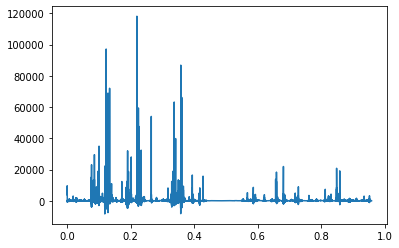

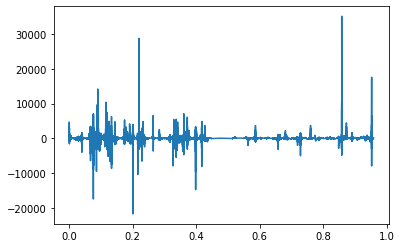

MemoryError: Unable to allocate 68.6 GiB for an array with shape (95933, 95933) and data type float64

In [6]:
for i in range(N):
    array_SmoothFP[i], array_resOpt[i] = global_estimation(array_Q_GS[i], param_model, opt=True, param_bayopt=param_bayopt)